# Recurrent Neural Networks: Introduction

While CNNs work with filters or kernels that are applied in local patches of our data, RNNs work with sequences of data in which the order is important.
We have a sequence of elements (e.g., a time series or a sentence of words) and the goal of a RNN is to predict the next element(s) given the sequence, i.e., we want to forecast.

**Overview of the Notebook:**
1. Some Notes on the Theory
2. Sine-Wave Prediction with SimpleRNN
3. Sine-Wave Prediction with LSTM units + EarlyStopping
4. Forecasting into the future of a Sine Wave

## 1. Some Notes on the Theory

### (Very) Basic Theory

Examples of sequences: time series (e.g., sales), sentences, audio, car trajectories, music, etc.

Note that the **order or history is important; actually that's one of the tings is supposed to be understood/learnt.**
From that intuitive idea, we can derive how a recurrent neuron of a RNN is built: **previous outputs are fed back as inputs!**

Some properties:
- Recurrent neurons are also called *memory cells*
- RNNs are very flexible in terms of how outputs are converted into inputs
    - We can pass single vector of values
    - We can pass a sequence
    - We can pass entire layer outputs as inputs again to the same layer
- Typical architectures
    - **Sequence-to-sequence** (aka. *many to many*): we pass a sequence and exppect a sequence. For example, we could train a chatbot with Q-A sequences.
    - **Sequence-to-vector** (aka. *many to one*): we pass a sequence and expect an element. For example, we can use that architecture to generate text.
    - **Vector-to-sequence** (aka. *one to many*): for instance, given a word, predict the next 5.
- Major drawbacks of RNNs:
    1. The **vanishing gradient**, as in all other ANNs.
    2. We pass the previous output as input, so **we forget older elements**. It would be great to keep track of longer history, not only the short-term one. The **Long Short Term Memory Units (LSTMs)** address that.

### Exploding and Vanishing Gradients

Complex data usually requires more complex architectures that consist of more hidden layers.

When we train, we iteratively compute the derivative of the error (i.e., the difference between the expected and predicted output) with respect to the weights.
That error derivative is backpropagated to the neuron weights using the rule of chain and each weight is updated so that the error becomes smaller.
**Since we use the rule of chain for computing the derivative, we have chained multiplications of values; if the multiplied values are small, the resulting gradient becomes very small (it vanishes), and it becomes gigant if the values are big (it explodes).**
That is not desired, since we cannot accurately control how to change the weights: usually, too small insignificant changes are computed due to the vanishing gradient, especially closer to the input layers. Thus, basic patterns that should be detected in the first layers are not learnt!

The vanishing gradient is particularly string in RNNs.

Some points to take into account regarding the the **vanishing gradient**:
- The **sigmoid activation** makes the vanishing gradient worse: we squeeze/map the signals to the [0,1] region, but the slope (i.e., derivative) of the activation function is very small!
    - Better, use the ReLu (rectified linear unit): max(x,0).
    - Other options: leaky ReLu, ELU, etc.
- **Batch normalization** avoids also the vanishing gradient: batches of samples are normalized using the mean and the standard deviation of the batch.
- **Xavier initialization**: a method for choosing different initial weight values. Basically, initial values are set to belong to a uniform distribution scaled by `sqrt(6)/sqrt(in + out connections)`; it improves alleviates diminishing gradients.
- **Gradient clipping**: we clip a gradient when it reaches a given limit value; a drity trick that seems to work sometimes.
- **LSTM units** also reduce the phenomenon of the vanishing gradient, apart from bringing some advantages to reguar recursive neurons. However, exploding gradients can still occur.

### LSTM and GRU: Long Short Term Memory Units and Gated Recurrent Units

A simple recursive neuron takes its previous output $h(t-1)$ as additional input to the regular input $x(t)$.
The output $h(t)$ is usually computed by multiplying the weights to the concatenated inputs and applying the hyperbilic tangent as activation function:

$h(t) = \mathrm{tanh}(w\cdot[h(t-1)^{T},x(t)^{T}]^{T} + b)$

Recall that since the structures of RNNs are quite flexible, we could do that per neuron or per layer.

A **long short term memory** neuron is more sophisticated, as it consits of three entries and two exits:

- As recurrent outputs, we have short-term ($h$) and long-term ($c$) memory signals; their output value at time $t-1$ is also input at time $t$
- The short-term output $h$ is also the output that goes to the next neuron/layer
- Additionally we have the regular input $x$ coming from previous neurons/layers

Internally, several gates (paths) are distinguished (forget, input/update, output).
The general idea is that irrelevant signals are forgotten, while relevant data is preserved;
that is achieved by appliying sigmoid and tanh activations to the values and performing summations and mutiplications between them.

The following figure from the Wikipedia displays the internal operations:

![LSTM cell - source: Wikipedia](pics/LSTM_Cell.png)

Image Source: [Wikipedia article on LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory)

There are several variations of that LSTM unit, such as
- **Peephole** units, which concatenate internal values
- **Gated Recurrent Units (GRUs)**, which combine forget an input gates to a single upddate gate, simplifying the unit

Although LSTMs are the default units used in RNNs, GRUs are getting more attention and are being deploying more and more lately.

![GRU cell - source: Wikipedia](pics/GRU_Cell.png)

Image Source: [Wikipedia article on GRU](https://en.wikipedia.org/wiki/Gated_recurrent_unit)

### Interesting Links

- [The Unreasonable Effectiveness of Recurrent Neural Networks, by Andrej Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
- [Exploring LSTMs, by Edwin Chen](http://blog.echen.me/2017/05/30/exploring-lstms/)
- [When to use GRU over LSTM? Stackexchange](https://datascience.stackexchange.com/questions/14581/when-to-use-gru-over-lstm)

### Practical Considerations with Time Series

- Time series on which we'd like to learn and predict need to have underlying patterns
- Enough data needs to be used to be fed to the network to learn all trends and seasonality components
    - We have a general trend component, lower frequency
    - We have also a seasonality component, higher frequency
- Thus, domain knowledge and experience is often necessary
- One possible approach is to work in batches of datapoints which are like windows in time and to predict one datapoint in the future for the given batch
    - Complete sequence: [0,1,2,3,4,5,6,7,8,9]
    - One possible batch: in [0,1,2,3], prediction [4]
    - Another batch: in [1,2,3,4], prediction [5]
    - If we want to predict more than one data point, we incorporate the prediction to our in batch removing the eldest datapoint
        - [6,7,8,9] -> [10]
        - [7,8,9,10] -> [11.1]
        - [8,9,10,11.1] -> [12.2]
        - ...
        - The further we go in time, the worse the prediction is expected to be!
- We need to perform a train/test split and early stopping
    - The test split is usually the last part of the series which contains enough data to model the general trend and the seasonality
    - The length of the input batch needs to be smaller than the length of the test split, bacause several batches need to be taken from the test split during training validation (with early stopping)
    - Once we have trained, we can compute the RMSE of the predicted and test split values
    - Having as reference the RMSE of the test split, we can vary several params and see what happens
        - The length of the test split
        - The length of a batch
        - The number of units/neurons in the model
        - ...
- Univariate vs. Multivariate: we basically follow the same calls, but `n_features` changes
    - For univariate cases `n_features=1`, otherwise, it has as value the number of fetures or dimensions of the signal.
    - Note that in a multivariate timeseries all values of all features predict the values of the same features in the future; thus, we should not mix it with a multivariate regression model in which we have *independent* and *dependent* (i.e., *predicted*) variables.
    - Note that it is better to work with SARIMAX or related models if we have a multivariate timeseries, because they are more interpretable.
    

## 2. Sine Wave Prediction

In [14]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

### 2.1 Create/Load the Dataset

In [15]:
# First, we create our sine wave: y = sin(x)
x = np.linspace(0,50,501)

In [16]:
y = np.sin(x)

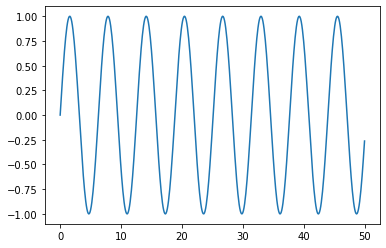

In [17]:
plt.plot(x,y)

In [18]:
# We conver our sine wave to be our dataset / dataframe
# If we have datetime values, we can use
# - parse_dates=True, or
# - infer_datetime_format=True
df = pd.DataFrame(data=y,index=x,columns=["Sine"])

In [19]:
df.head()

,Sine
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418


### 2.2 Define the train/test split

In [20]:
len(df)

501

In [21]:
# We choose a percent of the dataset to be the test set
# That percent is taken from the end of the dataset
test_percent = 0.1

In [22]:
test_point = np.round(len(df)*test_percent)

In [23]:
test_point

50.0

In [24]:
test_ind = int(len(df)-test_point)

In [25]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [26]:
test

,Sine
45.1,0.899097
45.2,0.938307
45.3,0.968142
45.4,0.988304
45.5,0.998591
45.6,0.998900
45.7,0.989229
45.8,0.969673
45.9,0.940429
46.0,0.901788


### 2.3 Scale the Data

In [27]:
# Now, we need to scale our data
from sklearn.preprocessing import MinMaxScaler

In [28]:
scaler = MinMaxScaler()

In [29]:
scaler.fit(train)

MinMaxScaler()

In [30]:
scaled_train = scaler.transform(train)

In [31]:
scaled_test = scaler.transform(test)

### 2.4 Define the Batches with a Generator

In [12]:
# We create batches using a very helpful class that provides a generator
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [19]:
# Utility class for generating batches of temporal data
#help(TimeseriesGenerator)

In [2]:
# Length of output sequences (in number of time steps)
# 2: we take 2 datapoints to predict the next
# Be aware: the length should be enough to learn ALL major trends + seasonality!
# That means often longer than a year or a similar equivalent cycle
# Also: 
# - the larger the length, the longer the training time
# - the length must be smaller than the length of the test split in case we do early stopping validation
length = 25
# Number of timeseries samples in each batch (1 performs well in general for timeseries)
batch_size = 1

In [21]:
# In our case, the data and the targets are the very same dataset
generator = TimeseriesGenerator(data=scaled_train,
                                targets=scaled_train,
                                length=length,
                                batch_size=batch_size)

In [22]:
# We explore what the generator does
len(scaled_train)

451

In [23]:
# The length of the generator will be
# len(data) - length
# because we can have that much subsets of sequences of the defined length
len(generator)

426

In [24]:
# We check the first element of the generator
X,y = generator[0]

In [25]:
X

array([[[0.49999912],
        [0.54991622],
        [0.59933458],
        [0.64776041],
        [0.69470985],
        [0.73971381],
        [0.78232262],
        [0.82211054],
        [0.85868004],
        [0.89166571],
        [0.92073798],
        [0.94560637],
        [0.9660224 ],
        [0.98178208],
        [0.99272794],
        [0.99875061],
        [0.99978993],
        [0.9958355 ],
        [0.98692684],
        [0.97315296],
        [0.95465148],
        [0.93160726],
        [0.90425056],
        [0.87285471],
        [0.83773342]]])

In [26]:
y

array([[0.79923759]])

### 2.5 Simple RNN Model

In [52]:
# See previous section on the definition of the generator
length = 50
batch_size = 1
generator = TimeseriesGenerator(data=scaled_train,
                                targets=scaled_train,
                                length=length,
                                batch_size=batch_size)

In [6]:
from tensorflow.keras.models import Sequential

In [7]:
from tensorflow.keras.layers import Dense,SimpleRNN,LSTM

In [10]:
# We have one feature X, trying to predict y
# The feature is the input variable, in this case the sine wave
n_features = 1
model = Sequential()
# We need to link the units to the length: same number, double, etc.
# Choosing 100 units for such a time series is sensible
# We can also add acivation='relu'
model.add(SimpleRNN(units=100,input_shape=(length,n_features)))
# We want our output to be a single number
model.add(Dense(n_features))
# Loss function for continuous values: MSE
model.compile(optimizer='adam',loss='mse')

In [61]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_6 (SimpleRNN)     (None, 100)               10200     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


In [62]:
# We train with the generator
# Note that RNNs require more time for training than other ANNs!
model.fit_generator(generator,epochs=5)

Epoch 1/5
401/401 [==============================] - 84s 210ms/step - loss: 0.0078
Epoch 2/5
401/401 [==============================] - 84s 209ms/step - loss: 9.1756e-04
Epoch 3/5
401/401 [==============================] - 84s 208ms/step - loss: 4.3631e-06
Epoch 4/5
401/401 [==============================] - 84s 208ms/step - loss: 2.2092e-05
Epoch 5/5
401/401 [==============================] - 84s 209ms/step - loss: 3.0875e-04


In [63]:
# We get our loss history and plot it
# We can improve the traning adding a validation set + early stopping
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

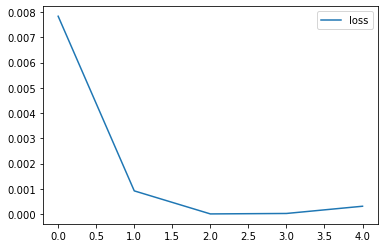

In [64]:
losses.plot()

In [65]:
# Inference
first_eval_batch = scaled_train[-length:]

In [66]:
first_eval_batch

array([[8.37405820e-01],
       [7.98881698e-01],
       [7.57371240e-01],
       [7.13289205e-01],
       [6.67076045e-01],
       [6.19193508e-01],
       [5.70120021e-01],
       [5.20345908e-01],
       [4.70368497e-01],
       [4.20687145e-01],
       [3.71798252e-01],
       [3.24190300e-01],
       [2.78338972e-01],
       [2.34702398e-01],
       [1.93716581e-01],
       [1.55791039e-01],
       [1.21304709e-01],
       [9.06021693e-02],
       [6.39901882e-02],
       [4.17346643e-02],
       [2.40579672e-02],
       [1.11367167e-02],
       [3.10001778e-03],
       [2.81703720e-05],
       [1.95186738e-03],
       [8.85188786e-03],
       [2.06592891e-02],
       [3.72560954e-02],
       [5.84764771e-02],
       [8.41084070e-02],
       [1.13895779e-01],
       [1.47540969e-01],
       [1.84707803e-01],
       [2.25024924e-01],
       [2.68089497e-01],
       [3.13471233e-01],
       [3.60716695e-01],
       [4.09353821e-01],
       [4.58896644e-01],
       [5.08850150e-01],


In [67]:
# We need to reshape it
first_eval_batch = first_eval_batch.reshape((1,length,n_features))

In [74]:
# Predict the next element
model.predict(first_eval_batch)

array([[0.9457696]], dtype=float32)

In [76]:
# Compare it with the test split
scaled_test[0]

array([0.94955134])

In [85]:
# Now, we put everything in a for loop
test_predictions = []
current_batch = scaled_train[-length:].reshape((1,length,n_features))
# We need to refresh our current_batch, move it forward in time:
# We need to keep appending all the values of the previous current_batch, but
# - we remove first
# - we add the last predicted to the end
for i in range(len(test)):
    predicted = model.predict(current_batch)[0]
    test_predictions.append(predicted)
    # We move the current_batch one step forward, as said above
    # Be careful with the brackets and the slicing:
    # we're working with tensors that have several dimensions
    current_batch = np.append(current_batch[:,1:,:],[[predicted]],axis=1)

In [89]:
# We have our predictions for the entire test range now
# but first we nee to unscale them
#test_predictions
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions

array([[ 0.89153383],
       [ 0.92998901],
       [ 0.95859913],
       [ 0.97500791],
       [ 0.98228594],
       [ 0.97873639],
       [ 0.96544848],
       [ 0.94388381],
       [ 0.91154247],
       [ 0.87013128],
       [ 0.82011159],
       [ 0.76217252],
       [ 0.69667327],
       [ 0.62358401],
       [ 0.54494871],
       [ 0.46128378],
       [ 0.37150464],
       [ 0.27865446],
       [ 0.18275994],
       [ 0.08370116],
       [-0.01623447],
       [-0.11674867],
       [-0.21803081],
       [-0.3164802 ],
       [-0.41321228],
       [-0.50782829],
       [-0.59693089],
       [-0.68098296],
       [-0.75870585],
       [-0.82961116],
       [-0.89228421],
       [-0.94549442],
       [-0.98970304],
       [-1.02362643],
       [-1.04669489],
       [-1.05980016],
       [-1.06076997],
       [-1.05132523],
       [-1.03224916],
       [-1.00153372],
       [-0.96112182],
       [-0.91201984],
       [-0.8537702 ],
       [-0.78734489],
       [-0.71374042],
       [-0

In [90]:
# We extend the test dataframe
test.head()

,Sine
45.1,0.899097
45.2,0.938307
45.3,0.968142
45.4,0.988304
45.5,0.998591


In [93]:
# We extend the test dataframe withth eunscaled (true) predictions
# We can ignore the warning
test['Predictions'] = true_predictions

/Users/mxagar/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [94]:
test.head()

,Sine,Predictions
45.1,0.899097,0.891534
45.2,0.938307,0.929989
45.3,0.968142,0.958599
45.4,0.988304,0.975008
45.5,0.998591,0.982286


<AxesSubplot:>

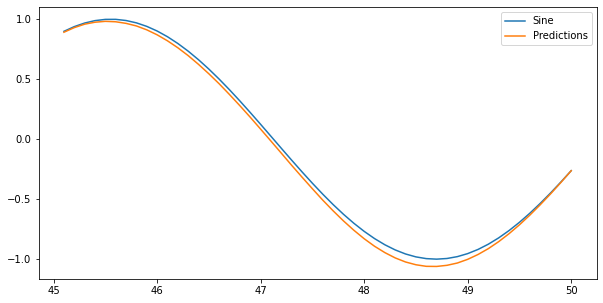

In [97]:
# We plot the result
# We see that the RNN did a nice job, but as we go further away in time
# the result is worse; that is to be expected,
# because we are prediction on top of predicted data as we step forward
test.plot(figsize=(10,5))

## 3. Sine-Wave Prediction with LSTM units + EarlyStopping

The previous implementation required a long time for traning.
We are going to check how it is possible to improve the results using **LSTM units and early stopping**.

In [96]:
from tensorflow.keras.callbacks import EarlyStopping

In [98]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [32]:
# We need to create a valudation generator
# BUT: now, our legth needs to be smaller than the size of the test split
# otherwise we cannot sample in the test split for validation.
# Therefore, we re-define our training generator too, with a new length
# (it needs to be at least 1 elemen shorter)
# Note: both the training and validation ggenerators take the same length!
length = 49
generator = TimeseriesGenerator(scaled_train,
                               scaled_train,
                               length=length,
                               batch_size=1)
validation_generator = TimeseriesGenerator(scaled_test,
                                          scaled_test,
                                          length=length,
                                          batch_size=1)

In [104]:
from tensorflow.keras.models import Sequential

In [105]:
from tensorflow.keras.layers import Dense,SimpleRNN,LSTM

In [107]:
n_features = 1
model = Sequential()
# We need to link the units to the length: same number, double, etc.
# Now, we use LSTM instead of SimpleRNN
model.add(LSTM(units=100,input_shape=(length,n_features)))
# We want our output to be a single number
model.add(Dense(n_features))
# Loss function for continuous values: MSE
model.compile(optimizer='adam',loss='mse')

In [110]:
# We train with an early stop callback
model.fit_generator(generator,
                    epochs=20,
                    validation_data=validation_generator,
                    callbacks=[early_stop])

Epoch 1/20
402/402 [==============================] - 262s 651ms/step - loss: 0.0126 - val_loss: 2.1070e-05
Epoch 2/20
402/402 [==============================] - 206s 512ms/step - loss: 1.5970e-04 - val_loss: 2.5663e-06
Epoch 3/20
402/402 [==============================] - 204s 508ms/step - loss: 7.3569e-04 - val_loss: 6.7972e-05
Epoch 4/20
402/402 [==============================] - 204s 509ms/step - loss: 6.4677e-05 - val_loss: 1.6938e-05


In [112]:
# After training, we forecast into the future in the test split
test_predictions = []
current_batch = scaled_train[-length:].reshape((1,length,n_features))
# We need to refresh our current_batch, move it forward in time:
# We need to keep appending all the values of the previous current_batch, but
# - we remove first
# - we add the last predicted to the end
for i in range(len(test)):
    predicted = model.predict(current_batch)[0]
    test_predictions.append(predicted)
    # We move the current_batch one step forward, as said above
    # Be careful with the brackets and the slicing:
    # we're working with tensors that have several dimensions
    current_batch = np.append(current_batch[:,1:,:],[[predicted]],axis=1)

In [113]:
# We have our predictions for the entire test range now
# but first we nee to unscale them
#test_predictions
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions

array([[ 0.90135338],
       [ 0.93843587],
       [ 0.96591125],
       [ 0.98342867],
       [ 0.99083139],
       [ 0.98811523],
       [ 0.9754069 ],
       [ 0.9529502 ],
       [ 0.92108617],
       [ 0.8802386 ],
       [ 0.83089923],
       [ 0.77361605],
       [ 0.70898391],
       [ 0.63763748],
       [ 0.56024577],
       [ 0.47750958],
       [ 0.39016003],
       [ 0.29895946],
       [ 0.20470107],
       [ 0.10821206],
       [ 0.0103537 ],
       [-0.08797666],
       [-0.18584688],
       [-0.28229268],
       [-0.37632422],
       [-0.46693656],
       [-0.55312445],
       [-0.63390174],
       [-0.70832389],
       [-0.7755115 ],
       [-0.83467428],
       [-0.88513088],
       [-0.92632493],
       [-0.95783468],
       [-0.97937652],
       [-0.99080302],
       [-0.99209582],
       [-0.98335534],
       [-0.96478886],
       [-0.93669715],
       [-0.89946239],
       [-0.85353648],
       [-0.7994311 ],
       [-0.73770976],
       [-0.66898181],
       [-0

In [114]:
# We extend the test dataframe withth eunscaled (true) predictions
# We can ignore the warning
test['LSTM Predictions'] = true_predictions

/Users/mxagar/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<AxesSubplot:>

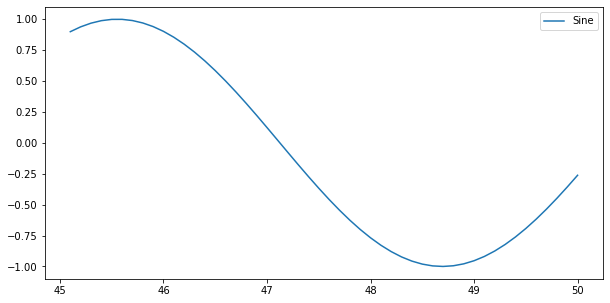

In [33]:
# Now we plot our results
# Ground truth (Sine), SimpleRNN predictions, LSTM predictions
# We see that LSTMs seem to yield the best results
test.plot(figsize=(10,5))

In [37]:
# Compute the RMSE
from sklearn.metrics import mean_squared_error

In [ ]:
np.sqrt(mean_squared_error(test['Sine'],test['LSTM Predictions']))

## 4. Forecasting

After we have checked whether our model works, we train it with the complete dataset to forecast into the future.
For that, we basically modify the code we've generated so far.

In [117]:
from sklearn.preprocessing import MinMaxScaler

In [119]:
full_scaler = MinMaxScaler()

In [125]:
# The dataframe df contains the whole dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 501 entries, 0.0 to 50.0
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sine    501 non-null    float64
dtypes: float64(1)
memory usage: 7.8 KB


In [126]:
scaled_full_data = full_scaler.fit_transform(df)

In [128]:
# We create our generator with the scaled full data
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [129]:
length = 50
batch_size = 1
generator = TimeseriesGenerator(data=scaled_full_data,
                                targets=scaled_full_data,
                                length=length,
                                batch_size=batch_size)

In [130]:
# We copy/create our model with the LSTM units
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,SimpleRNN,LSTM

In [131]:
n_features = 1
model = Sequential()
model.add(LSTM(units=100,input_shape=(length,n_features)))
model.add(Dense(n_features))
model.compile(optimizer='adam',loss='mse')

In [132]:
# We train it, this time without early stopping;
# instead we train the number of epochs before the early stop before
model.fit_generator(generator,
                    epochs=4)

Epoch 1/4
451/451 [==============================] - 231s 513ms/step - loss: 0.0045
Epoch 2/4
451/451 [==============================] - 234s 519ms/step - loss: 4.2974e-04
Epoch 3/4
451/451 [==============================] - 234s 519ms/step - loss: 6.2929e-05
Epoch 4/4
451/451 [==============================] - 233s 517ms/step - loss: 3.9421e-04


In [148]:
# After training, we forecast into the future the range we want
forecast = []
steps_into_future = 100
current_batch = scaled_full_data[-length:].reshape((1,length,n_features))
for i in range(steps_into_future):
    predicted = model.predict(current_batch)[0]
    forecast.append(predicted)
    current_batch = np.append(current_batch[:,1:,:],[[predicted]],axis=1)

In [149]:
# We inverse the scaling
forecast = scaler.inverse_transform(forecast)

In [150]:
# Now we plot it
# Since we finish at 50.0 with stapsize 0.1 in our full dataset
# and we have steps_into_future steps, we start at 50.1 until 50.1+steps_into_future*0.1
forecast_index = np.arange(50.1,50.1+steps_into_future*0.1,step=0.1)

In [151]:
# Check lengths
print(len(forecast),len(forecast_index))

100 100


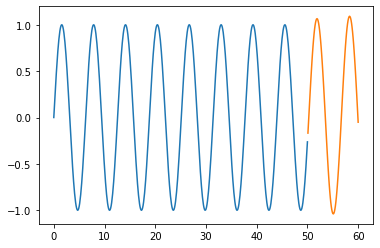

In [152]:
plt.plot(df.index,df['Sine'])
plt.plot(forecast_index,forecast)